# TFL Status and BLE RSSI analysis

In [17]:
# Importing Libraries and Functions
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, date, time, timedelta
from sklearn import datasets, linear_model
from copy import deepcopy
from matplotlib import style 
style.use("ggplot")
from sklearn.cluster import KMeans
import seaborn as sns
from datetime import datetime
from datetime import time
from mpl_toolkits.mplot3d import Axes3D

TFL Status
Aims:
Discover any trends in disruption times and develop a model which may predict disruption

BLE Devices
Aims:
Discover trends which indicate which room in the house the phone is in


In [3]:
tfl_data = pd.read_csv('line_status.csv') 
tfl_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30019 entries, 0 to 30018
Data columns (total 4 columns):
id                           30019 non-null object
timestamp                    30019 non-null object
statusSeverity               30019 non-null int64
statusSeverityDescription    30019 non-null object
dtypes: int64(1), object(3)
memory usage: 938.2+ KB


### TFL Data Analysis

The status types will be mapped as follows:

- Good Service = 0
- Minor Delays = 1
- Severe Delays = 1
- Service Closed = None
- Part Closure = 1
- Planned Closure = 1
- Part Suspended = 1
- Suspended = 1

such that a good service is 0 and any disruption is modelled as 1 in the simple mapping case


In [4]:
tfl_data = tfl_data.sort_values(by=['timestamp'])
# Clean Data
tfl_data['timestamp'] = tfl_data['timestamp'].map(lambda x: x.replace('T',' '))
tfl_data['timestamp'] = tfl_data['timestamp'].map(lambda x: x.replace('.443Z',''))
tfl_data['timestamp'] = tfl_data['timestamp'].map(lambda x: x.replace('.447Z',''))
tfl_data['timestamp'] = tfl_data['timestamp'].map(lambda x: x.replace('.45Z',''))

simple_map = {'Good Service':0, 'Minor Delays':1,'Severe Delays':1,'Service Closed':None,'Part Closure':1,'Planned Closure':1,'Part Suspended':1,'Suspended':1}
tfl_data['statusMapSimple'] = tfl_data['statusSeverityDescription'].map(lambda x: simple_map[x])

tfl_data.head()

,id,timestamp,statusSeverity,statusSeverityDescription,statusMapSimple
3300,bakerloo,2019-12-03 10:51:17,9,Minor Delays,1.0
3301,central,2019-12-03 10:51:17,10,Good Service,0.0
3310,waterloo-city,2019-12-03 10:51:17,10,Good Service,0.0
3309,victoria,2019-12-03 10:51:17,10,Good Service,0.0
3308,piccadilly,2019-12-03 10:51:17,10,Good Service,0.0


In [5]:
# Extract a single line
def line_data(lineID):
    return tfl_data[tfl_data['id']==lineID]

In [6]:
# Disruption Frequency
def timeFreq(linePD):
    linePD['timeFreq'] =  linePD['timestamp'].map(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S').time().replace(minute=0, second=0, microsecond=0))
    return linePD

tfl_data = timeFreq(tfl_data)


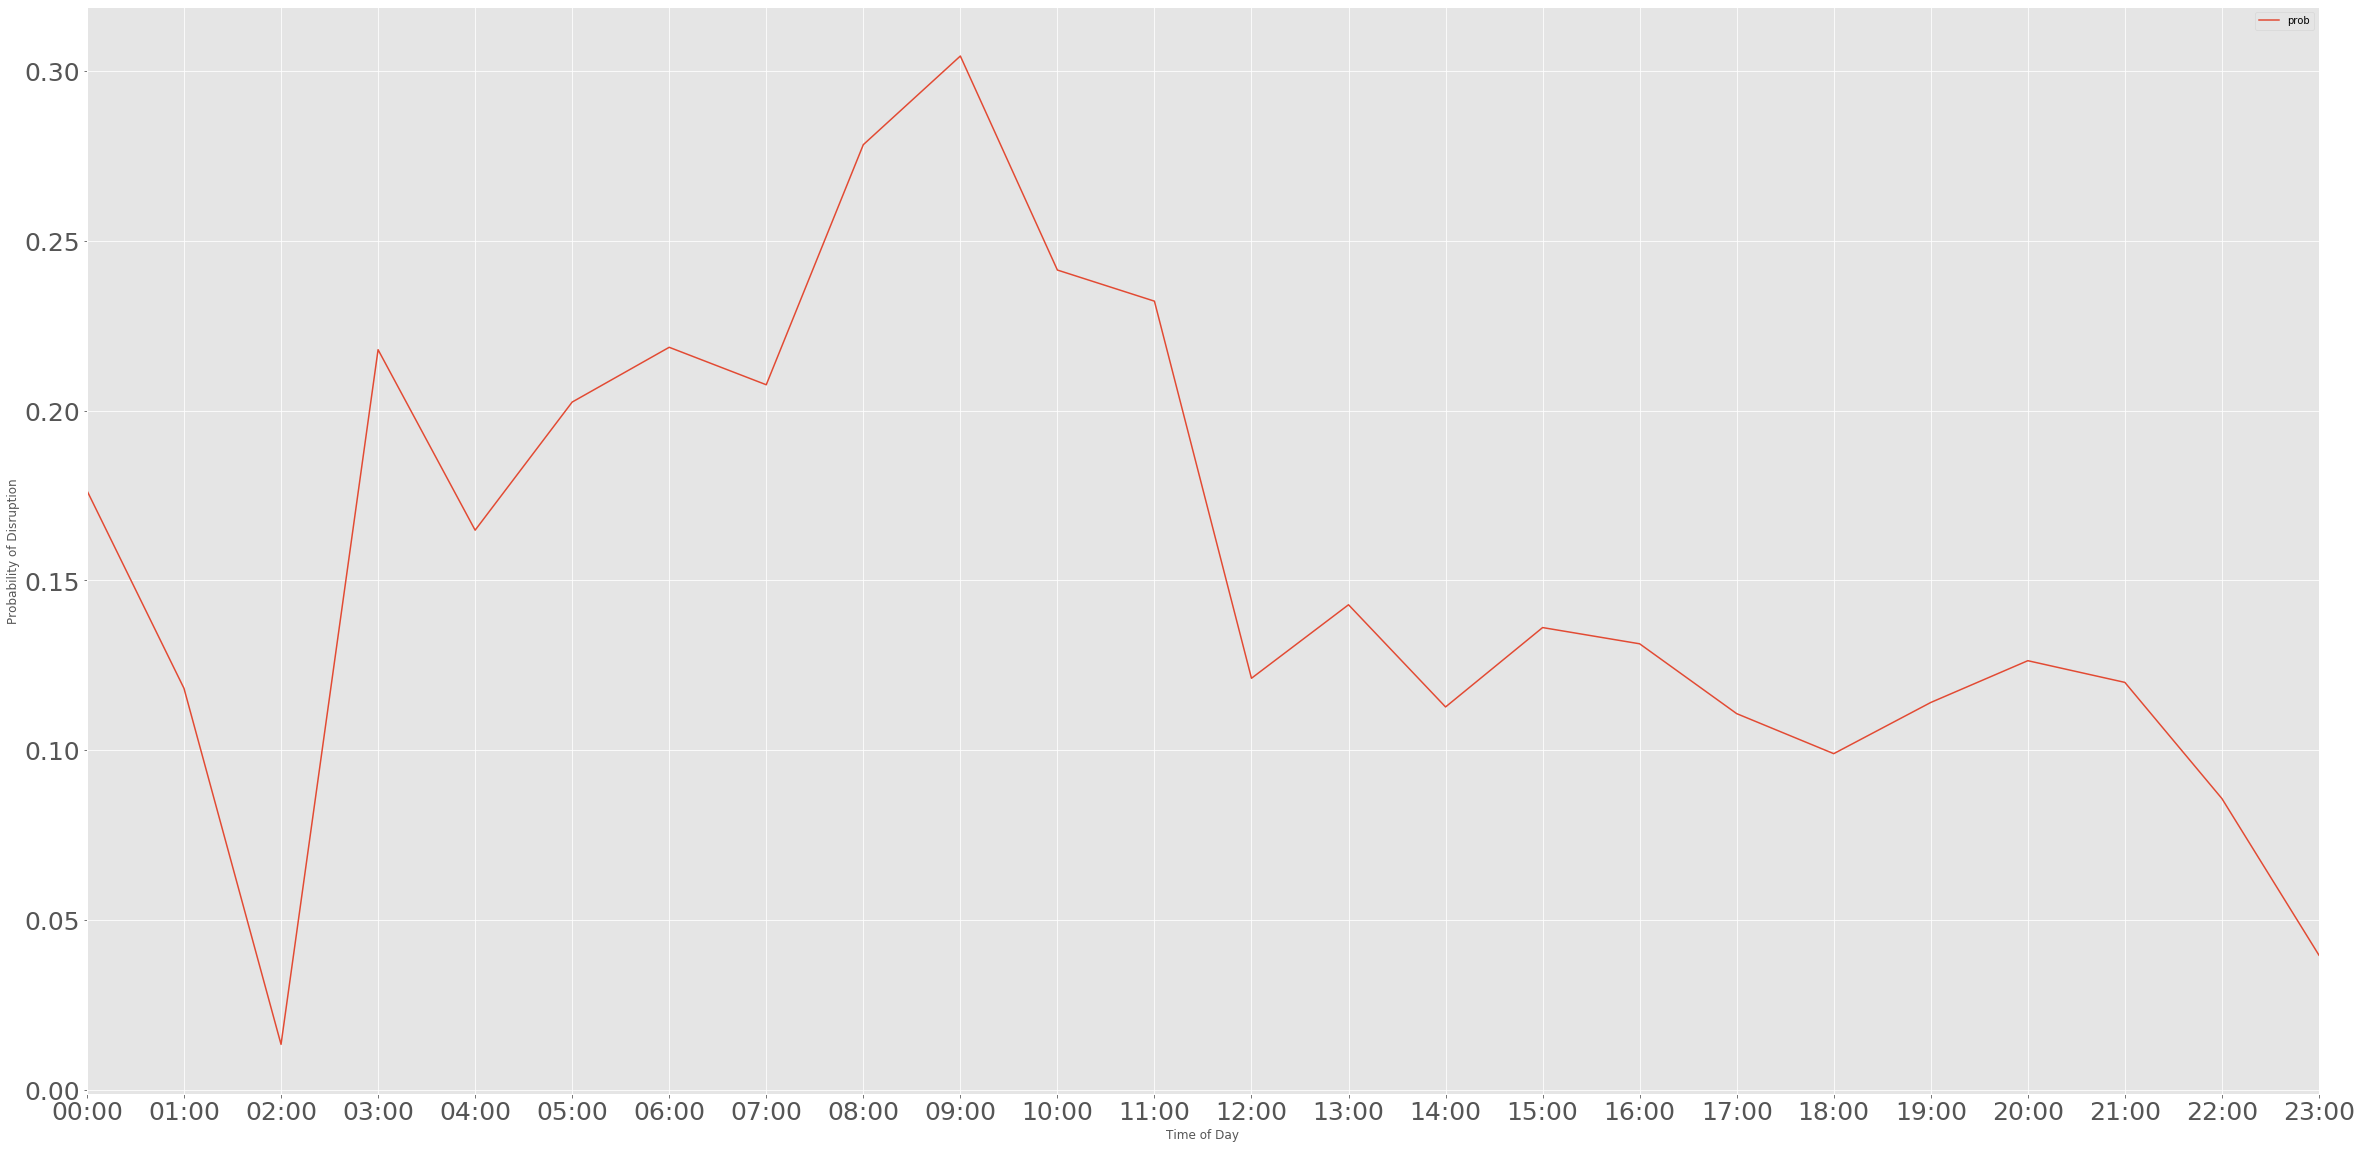

In [20]:
def disruptionFreq(linePD):
    disFreq = pd.crosstab(linePD.timeFreq, linePD.statusMapSimple).reset_index().rename_axis('',axis='columns') 
    disFreq['prob'] = disFreq[1]/(disFreq[0]+disFreq[1])
    return disFreq
    
tfl_df = disruptionFreq(tfl_data)
tfl_df = tfl_df.groupby(tfl_df['timeFreq']).mean()
tfl_df_plot = tfl_df.plot(y='prob',xticks=tfl_df.index, figsize=(40,20), fontsize=25).set(xlabel='Time of Day', ylabel='Probability of Disruption')


# BLE Device Data

In [8]:
ble_data = pd.read_csv('ble_devices.csv')
ble_data = ble_data.drop('name', 1)
ble_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25615 entries, 0 to 25614
Data columns (total 3 columns):
id           25615 non-null object
timestamp    25615 non-null object
rssi         25615 non-null int64
dtypes: int64(1), object(2)
memory usage: 600.5+ KB


In [9]:
# Clean data
ble_data['timestamp'] = ble_data['timestamp'].map(lambda x: x.replace('T',' '))
ble_data['timestamp'] = ble_data['timestamp'].map(lambda x: x.split('.')[0])  
 
# Set Time Frequency
ble_data['timestamp'] =  ble_data['timestamp'].map(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S').replace(microsecond=0))
ble_data = ble_data.set_index('timestamp')


bedroom = ble_data[ble_data['id']=='30:AE:A4:DD:A1:0E']
bedroom = bedroom.rename(columns={'rssi': 'bedroom_rssi'})
bedroom = bedroom.drop('id', 1)

hallway = ble_data[ble_data['id']=='30:AE:A4:DD:8B:36']
hallway = hallway.rename(columns={'rssi': 'hallway_rssi'})
hallway = hallway.drop('id', 1)

lounge = ble_data[ble_data['id']=='DC:A6:32:2B:8C:B2']
lounge = lounge.rename(columns={'rssi': 'lounge_rssi'})
lounge = lounge.drop('id', 1)



In [10]:
#ble_data = bedroom.append([hallway,lounge])
ble_data = bedroom.join(hallway)
ble_data = ble_data.join(lounge)
ble_data = ble_data.dropna()
ble_data = ble_data.sort_index()
ble_data.head()
ble_data.shape


(391, 3)

In [22]:
# KMeans Clustering
X = np.array(list(zip(ble_data['bedroom_rssi'], ble_data['hallway_rssi'], ble_data['lounge_rssi'])))
kmeans = KMeans(n_clusters = 3)
kmeans.fit(X)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_
#print(centroids)
#print(labels)

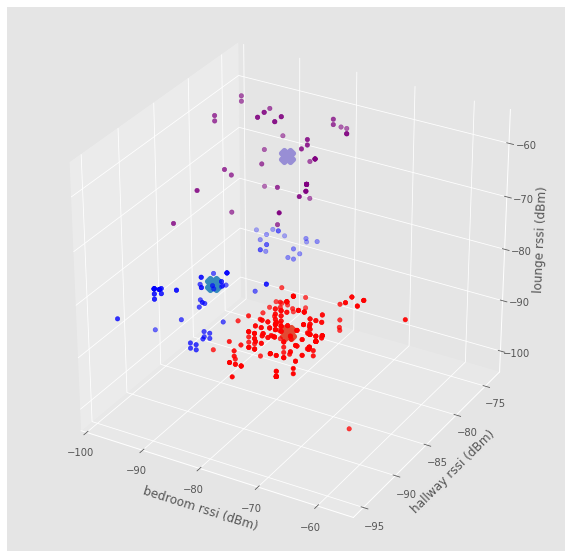

In [23]:
colour_mapping = {0:'red',1:'blue',2:'purple'}

rssi_plot = plt.figure(figsize=(10,10)).gca(projection='3d')

rssi_plot.scatter(centroids[0,0],centroids[0,1],centroids[0,2], marker = 'X', s=150, linewidths = 5, zorder = 10)

rssi_plot.scatter(centroids[1,0],centroids[1,1],centroids[1,2], marker = 'X', s=150, linewidths = 5, zorder = 10)

rssi_plot.scatter(centroids[2,0],centroids[2,1],centroids[2,2], marker = 'X', s=150, linewidths = 5, zorder = 10)


colour_map = [colour_mapping[label] for label in labels]
rssi_plot.scatter(ble_data['bedroom_rssi'], ble_data['hallway_rssi'], ble_data['lounge_rssi'], color=colour_map)


rssi_plot.set_xlabel('bedroom rssi (dBm)')
rssi_plot.set_ylabel('hallway rssi (dBm)')
rssi_plot.set_zlabel('lounge rssi (dBm)')
plt.show()